# Corona Virus Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rawData = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")

In [3]:
dataFrames = dict(states={}, counties={})
columns = ['cases', 'deaths']

def getTotal(): 
    if not "total" in dataFrames:
        dataFrames["total"] =rawData.groupby('date').sum()[columns]
    return dataFrames["total"]

def getState(state):
    if not state in dataFrames["states"]:
        statedf = rawData[rawData.state==state].groupby('date').sum()[columns]
        if statedf.empty:
            print (state + " is not in the data, did you spell it right? capitalization?")
            return 
        else:
            dataFrames["states"][state] = statedf
    return dataFrames["states"][state]

def getCounty(county):
    if not county in dataFrames["counties"]:
        countydf = rawData[rawData.county==county].groupby('date').sum()[columns]
        if countydf.empty:
            print(county + " is not in the data, did you spell it right? capitalization?")
            return
        else:
            dataFrames["counties"][county] = countydf
    return dataFrames["counties"][county]
        

In [4]:
getTotal().tail(2) # last two dates data to check how recent this data is


cases  deaths
date                      
2020-04-07  397752   12959
2020-04-08  429283   14803

In [5]:
def fitExponential(series):
    series = series.dropna()
    series = series[series>0]
    logseries = np.log(series)
    n = len(logseries)
    rate, intercept = np.polyfit(np.arange(n), logseries, 1) 
    base = np.exp(intercept)
    return (rate, base, n) 


In [6]:
def plotFitted(series, name, log=True): 
    (rate, base, n) = fitExponential(series)
    x = np.arange(n)
    series = series[-n:]
    if log:
        plt.semilogy()
    sbn.set(rc={'figure.figsize':(11.7,8.27)})
    sbn.scatterplot(x, series, label=f"{name} actual")
    sbn.lineplot(x, base * np.exp(rate*x) , label=f"{name} expected with constant exponential growth")
    plt.show()

In [7]:
plotFitted(getTotal()["cases"][-30:], "USA Total")

In [8]:
def growthRateAnalysis(series, name, n=30):
    rate, base, n = fitExponential(series[-n:])
    name = f"{name} {series.name}"
    formula = f"{series.name} = {np.round(base, 2)} * exp({np.round(rate, 4)} * day)"
    dailyGrowth = np.round(100 * (np.exp(rate) - 1), 2)
    daysToDoubling = np.round(np.log(2)/rate, 2)
    print(f"{name} exponential formula fitted with {n} points:")
    print(formula)
    print(f"fitted daily growth rate: {dailyGrowth} %, fitted days to doubling: {daysToDoubling}")
    deltas = series.diff(1)
    rates = 100*deltas/series
    data = {
        f"{name} day to day growth rate (%)":rates, 
        f"{name} 3 day moving average":rates.rolling(window=3).mean(), 
        f"{name} 5 day moving average":rates.rolling(window=5).mean(), 
    }
    df = pd.DataFrame(data).dropna()[-n:]
    gr = df.tail(1)[f"{name} 5 day moving average"].values[0]
    dailyGrowth = np.round(gr, 2)
    daysToDoubling = np.round(np.log(2)*100/gr, 2)
    print(f"actual daily growth rate: {dailyGrowth} %, actual days to doubling: {daysToDoubling}")    
    sbn.lineplot(data=df)
    plt.show()
    plotFitted(series[-n:], name)


In [9]:
growthRateAnalysis(getTotal()['cases'], "Total USA")

Total USA cases exponential formula fitted with 30 points:
cases = 1532.17 * exp(0.2202 * day)
fitted daily growth rate: 24.64 %, fitted days to doubling: 3.15
actual daily growth rate: 8.43 %, actual days to doubling: 8.22


In [10]:
def trajectoryPlot(series, name):
    deltas = series.diff(5)
    fullname = f"{series.name} in {name}"
    x = f"total {series.name}"
    y = f"new {series.name} since 5 days ago"
    data = {x: series, y: deltas}
    plt.loglog()
    df = pd.DataFrame(data).dropna()[-30:]
    sbn.lineplot(x, y, data=df, label=fullname)
    
trajectoryPlot(getTotal()['cases'], "USA")
trajectoryPlot(getState("California")['cases'], "CA")
trajectoryPlot(getCounty("San Francisco")["cases"], "SF")
plt.show()
trajectoryPlot(getTotal()['deaths'], "USA")
trajectoryPlot(getState("California")['deaths'], "CA")
trajectoryPlot(getCounty("San Francisco")["deaths"], "SF")
plt.show()

In [11]:
def laggedPlot(df, name):
    vals = df.copy()
    vals = df.dropna()[df.cases > 0]
    # show correlation with wide range of time lags
    for i in range(30):
        vals[i] = df.cases.shift(i)
    vals = vals.drop(columns='cases')
    vals = vals[vals.deaths > 0][-20:]
    corrs = vals.corr()[['deaths']].drop('deaths')
    lc = np.log(vals).corr()[['deaths']].drop('deaths')
    lc[0] = lc.deaths
    for i in [3, 5, 7]:
        lc[i] = lc.deaths.rolling(i).mean()
    lc = lc.dropna()
    corrdata = {
        f"{name} correlation of log of deaths to log of cases by # of days ago": lc[0],
        f"{name} correlation 3 day moving average": lc[3],
        f"{name} correlation 5 day moving average": lc[5],
        f"{name} correlation 7 day moving average": lc[7],
    }
    corrsdf = pd.DataFrame(corrdata)
    print(f"Correlations for {name}:")
    sbn.lineplot(data=corrsdf)
    plt.show()
    # dig deeper into an interesting set of time lags
    values = vals[["deaths"]].copy()
    ratios = vals[["deaths"]].copy()
    interesting = [7, 14]
    for i in [0, 3, 5, 7]:
        l = lc[i].dropna()
        lmax = l[l==max(l)] # max at this correlation moving average
        interesting += list(lmax.index)
    for i in sorted(list(set(interesting))):
        values[f"{name} cases {i} days ago"] = vals[i]
        ratios[f"{name} deaths/cases {i} days ago"] = vals.deaths/vals[i]
    ratios = ratios.drop(columns=['deaths'])
    print(f"Deaths vs Lagged Values For {name}:")
    plt.semilogy()
    sbn.lineplot(data=values, dashes=False)
    plt.show()
    print(f"Deaths / Lagged Values For {name}:")
    plt.semilogy()
    sbn.lineplot(data=ratios, dashes=False)
    plt.show()

    

In [12]:
# laggedPlot(getTotal(), "USA")
# laggedPlot(getState("California"), "CA")
# laggedPlot(getCounty("San Francisco"), "SF")

In [13]:
def analyse(counties=[], states=[], n=20):
    sbn.set(rc={'figure.figsize':(11.7,8.27)})
    names = counties + states + ["USA total:"]
    rates= []
    dfs = [getCounty(c) for c in counties] + [getState(s) for s in states] + [getTotal()] 
    print("Trajectory Plots to see if the curve is flattening:")
    for col in ["cases", "deaths"]:
        for df, name in zip(dfs, names):
            trajectoryPlot(df[col], name)
        plt.show()
    for df, name in zip(dfs, names):
        print(f"\n### Analysis for {name:} ###\n")
        growthRateAnalysis(df["cases"], name)
        growthRateAnalysis(df["deaths"], name)
        print(f"Trajectory plots for {name}, to see when the curve starts flattening")
        trajectoryPlot(df.cases, name)
        trajectoryPlot(df.deaths, name)
        plt.show()
        laggedPlot(df, name)


        
    
    

Trajectory Plots to see if the curve is flattening:


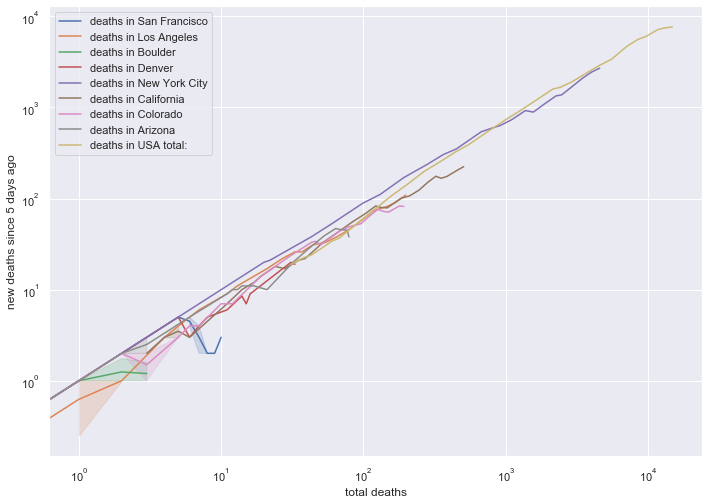


### Analysis for San Francisco ###

San Francisco cases exponential formula fitted with 30 points:
cases = 19.35 * exp(0.1367 * day)
fitted daily growth rate: 14.65 %, fitted days to doubling: 5.07
actual daily growth rate: 5.92 %, actual days to doubling: 11.72


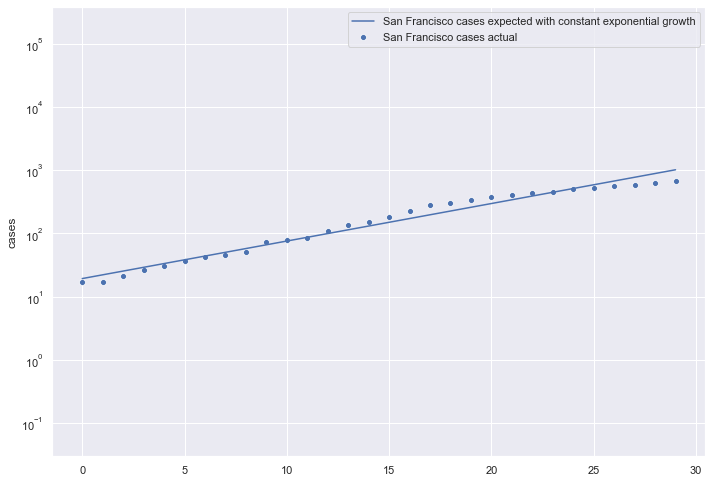

San Francisco deaths exponential formula fitted with 15 points:
deaths = 2.2 * exp(0.126 * day)
fitted daily growth rate: 13.43 %, fitted days to doubling: 5.5
actual daily growth rate: 6.72 %, actual days to doubling: 10.31


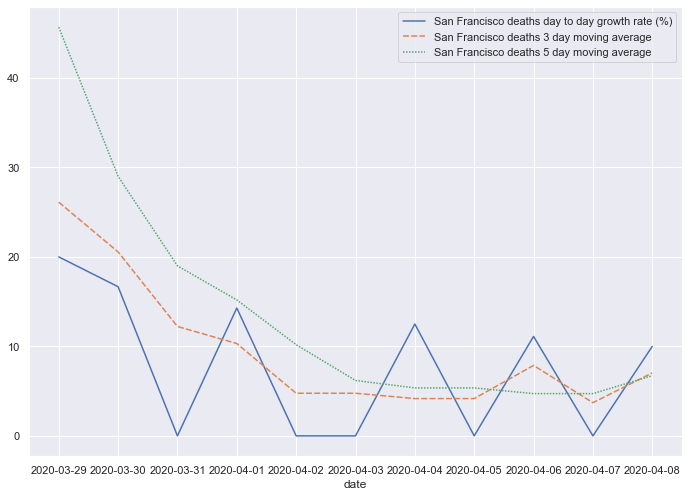

Trajectory plots for San Francisco, to see when the curve starts flattening


Correlations for San Francisco:


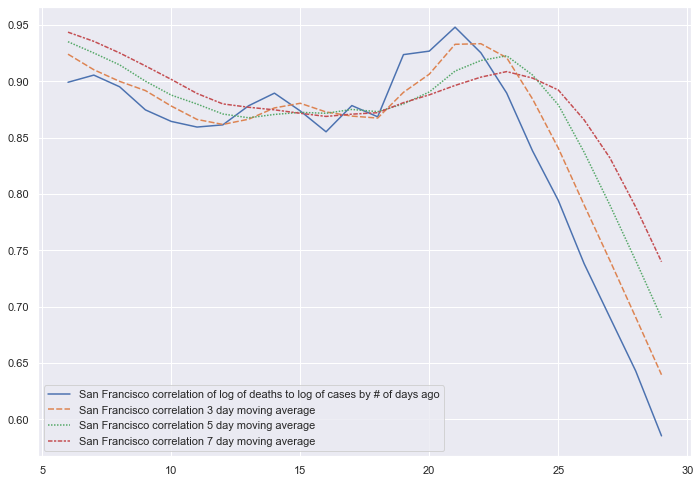

Deaths vs Lagged Values For San Francisco:


Deaths / Lagged Values For San Francisco:


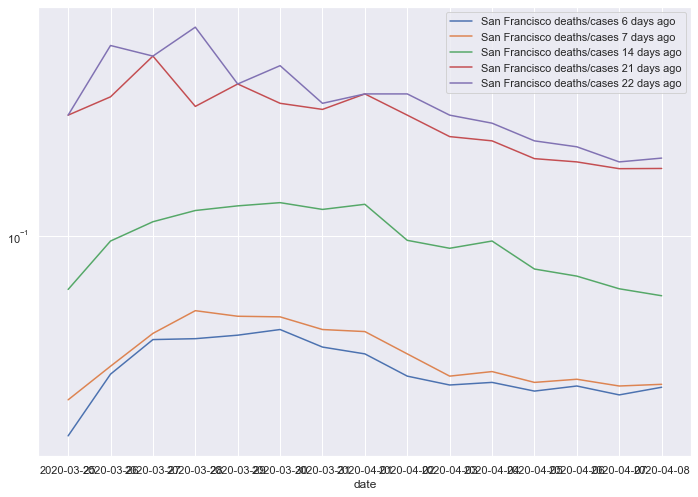


### Analysis for Los Angeles ###

Los Angeles cases exponential formula fitted with 30 points:
cases = 28.44 * exp(0.2128 * day)
fitted daily growth rate: 23.71 %, fitted days to doubling: 3.26
actual daily growth rate: 9.49 %, actual days to doubling: 7.31


Los Angeles deaths exponential formula fitted with 29 points:
deaths = 0.48 * exp(0.2264 * day)
fitted daily growth rate: 25.41 %, fitted days to doubling: 3.06
actual daily growth rate: 14.63 %, actual days to doubling: 4.74


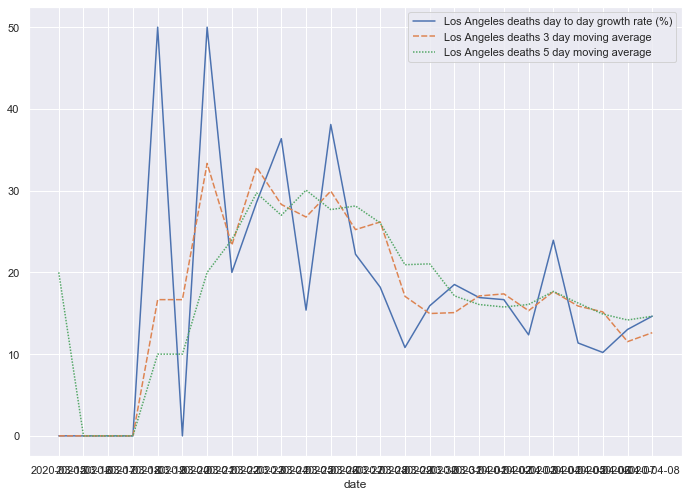

Trajectory plots for Los Angeles, to see when the curve starts flattening


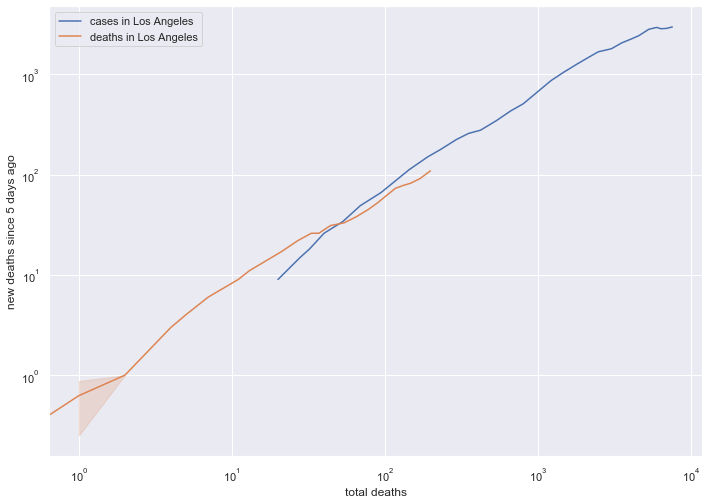

Correlations for Los Angeles:


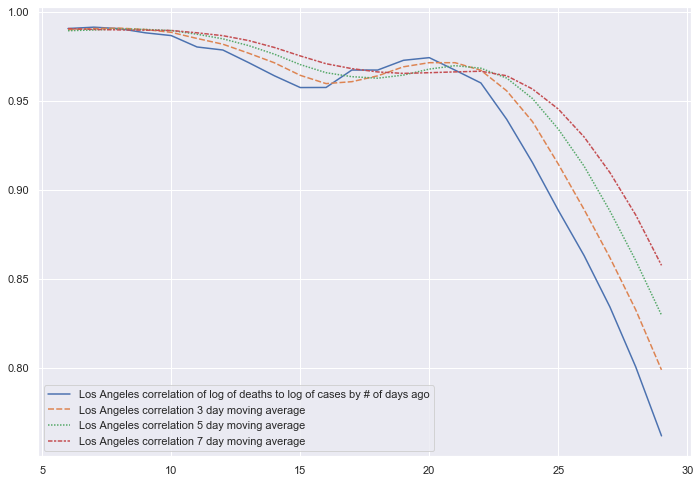

Deaths vs Lagged Values For Los Angeles:


Deaths / Lagged Values For Los Angeles:



### Analysis for Boulder ###

Boulder cases exponential formula fitted with 26 points:
cases = 5.77 * exp(0.1662 * day)
fitted daily growth rate: 18.08 %, fitted days to doubling: 4.17
actual daily growth rate: 7.06 %, actual days to doubling: 9.81


Boulder deaths exponential formula fitted with 13 points:
deaths = 0.96 * exp(0.1131 * day)
fitted daily growth rate: 11.98 %, fitted days to doubling: 6.13
actual daily growth rate: 6.67 %, actual days to doubling: 10.4


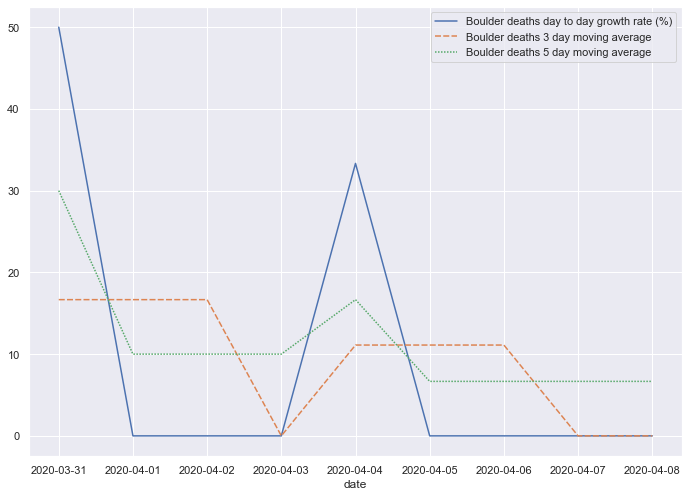

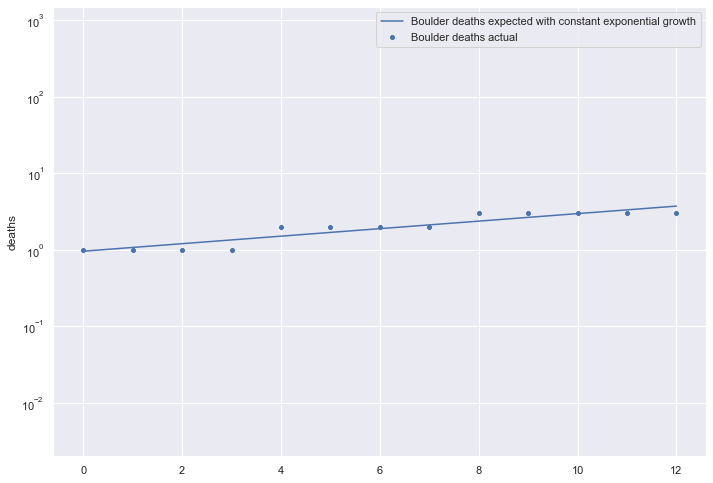

Trajectory plots for Boulder, to see when the curve starts flattening


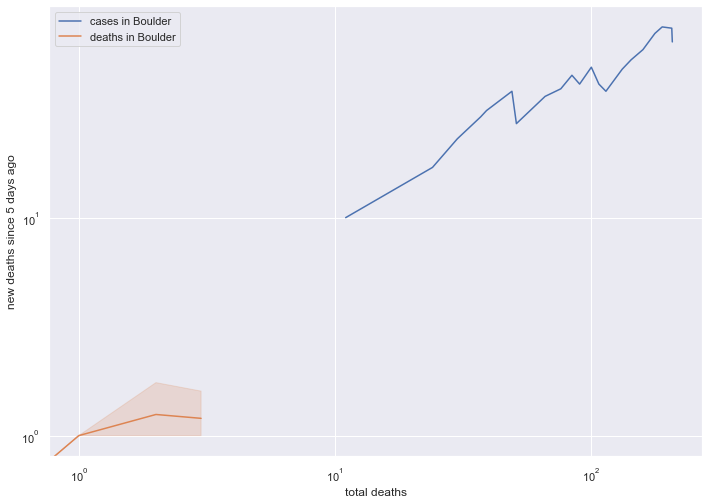

Correlations for Boulder:


Deaths vs Lagged Values For Boulder:


Deaths / Lagged Values For Boulder:



### Analysis for Denver ###

Denver cases exponential formula fitted with 30 points:
cases = 10.12 * exp(0.18 * day)
fitted daily growth rate: 19.72 %, fitted days to doubling: 3.85
actual daily growth rate: 5.02 %, actual days to doubling: 13.81


Denver deaths exponential formula fitted with 15 points:
deaths = 2.57 * exp(0.174 * day)
fitted daily growth rate: 19.01 %, fitted days to doubling: 3.98
actual daily growth rate: 12.7 %, actual days to doubling: 5.46


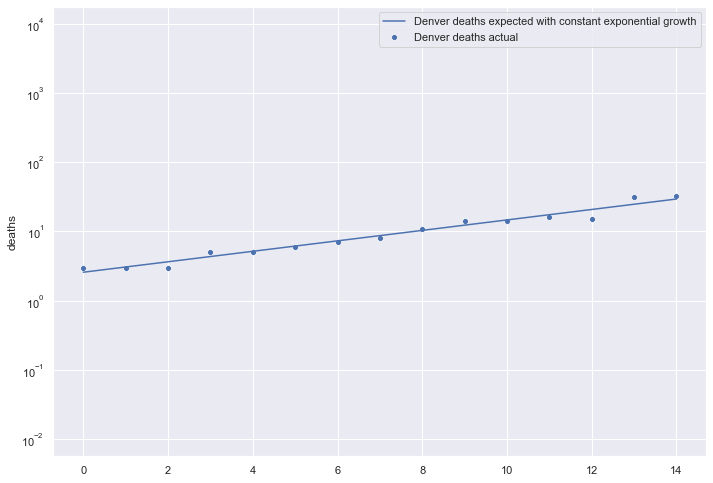

Trajectory plots for Denver, to see when the curve starts flattening


Correlations for Denver:


Deaths vs Lagged Values For Denver:


Deaths / Lagged Values For Denver:


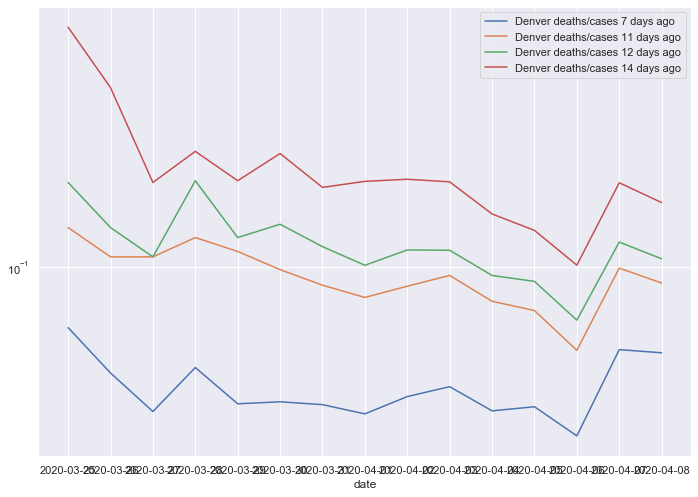


### Analysis for New York City ###

New York City cases exponential formula fitted with 30 points:
cases = 131.79 * exp(0.2656 * day)
fitted daily growth rate: 30.42 %, fitted days to doubling: 2.61
actual daily growth rate: 6.87 %, actual days to doubling: 10.09


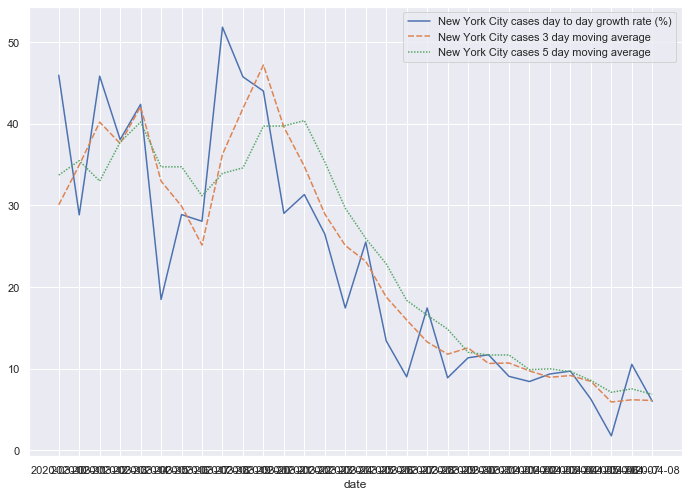

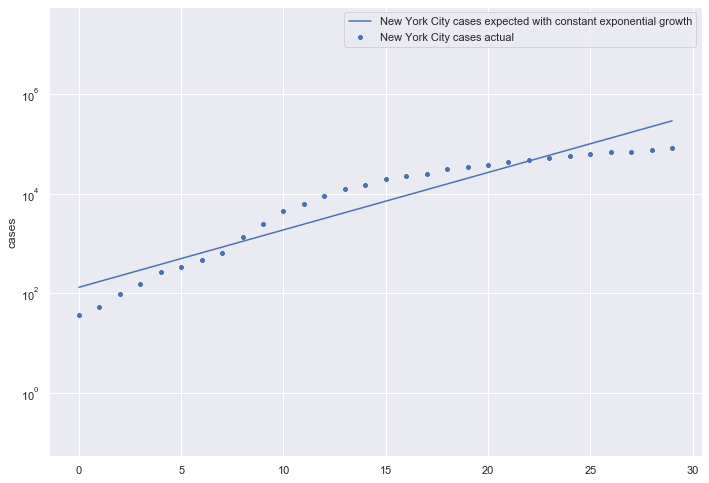

New York City deaths exponential formula fitted with 26 points:
deaths = 5.58 * exp(0.2984 * day)
fitted daily growth rate: 34.77 %, fitted days to doubling: 2.32
actual daily growth rate: 16.08 %, actual days to doubling: 4.31


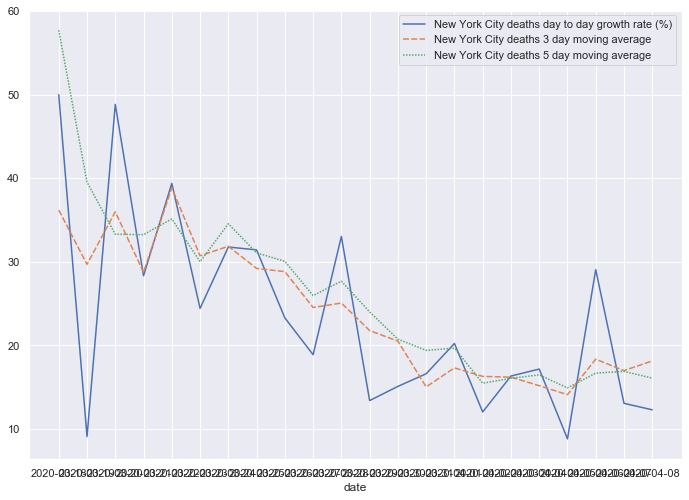

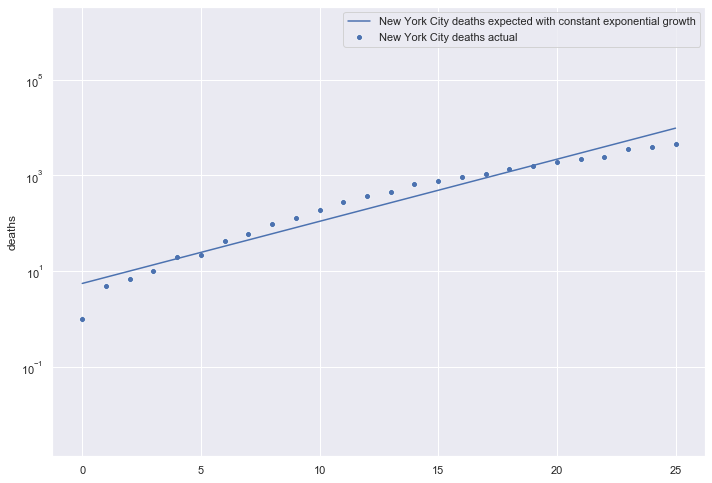

Trajectory plots for New York City, to see when the curve starts flattening


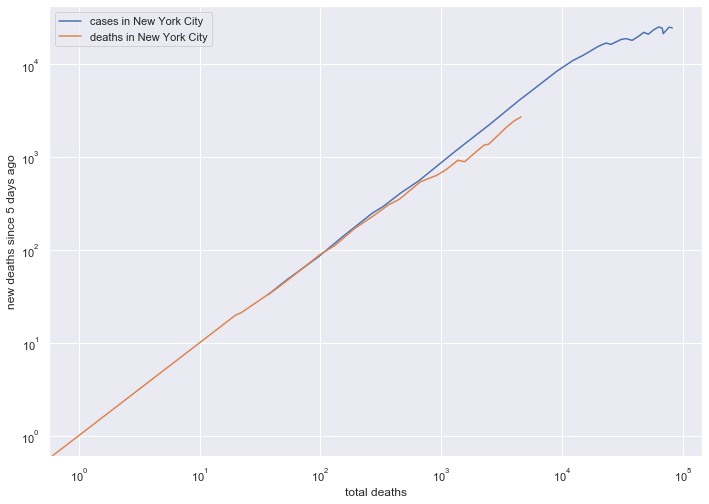

Correlations for New York City:


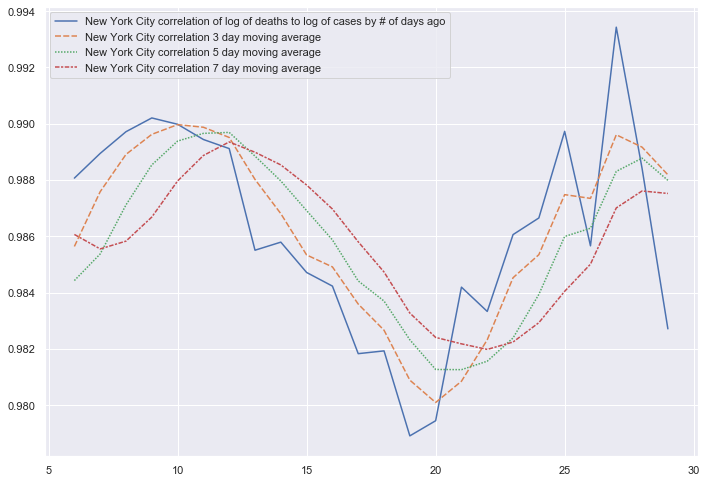

Deaths vs Lagged Values For New York City:


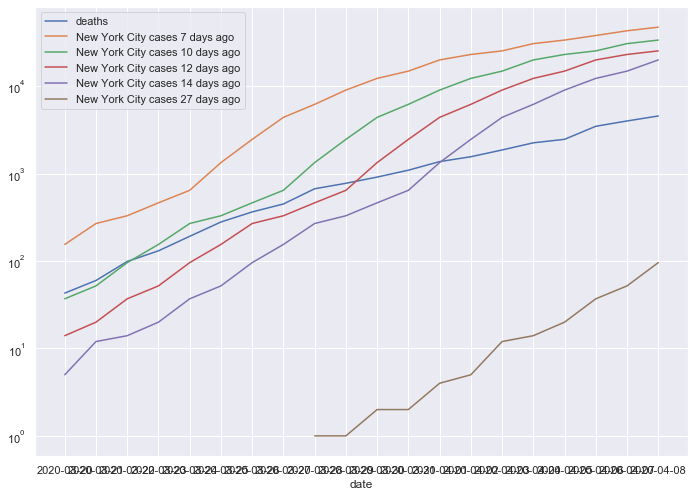

Deaths / Lagged Values For New York City:


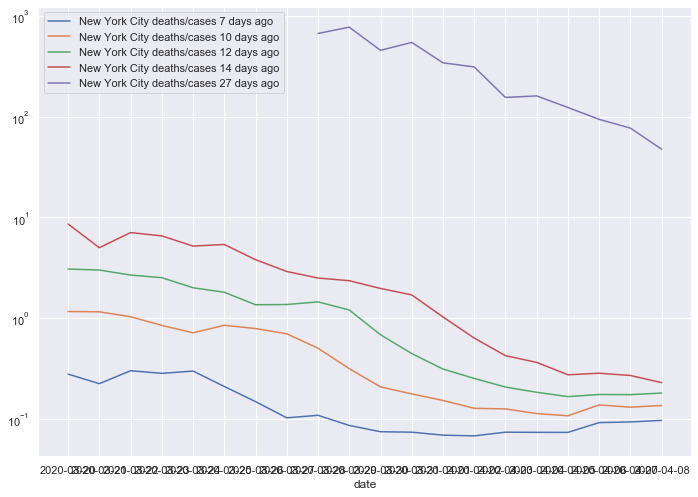


### Analysis for California ###

California cases exponential formula fitted with 30 points:
cases = 219.35 * exp(0.1683 * day)
fitted daily growth rate: 18.33 %, fitted days to doubling: 4.12
actual daily growth rate: 7.97 %, actual days to doubling: 8.7


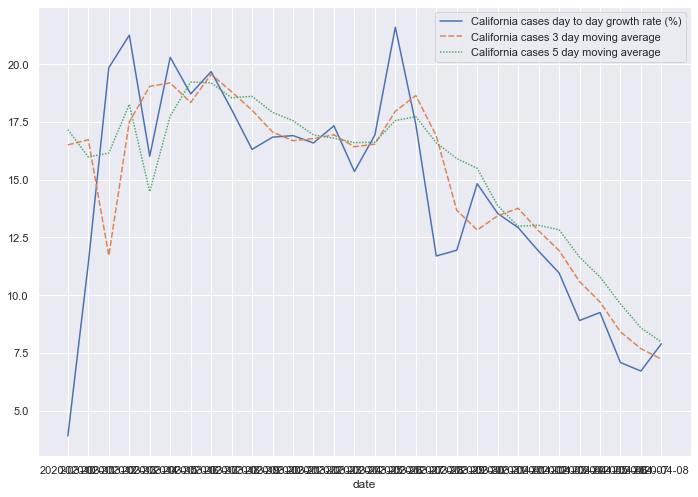

California deaths exponential formula fitted with 30 points:
deaths = 3.4 * exp(0.1845 * day)
fitted daily growth rate: 20.26 %, fitted days to doubling: 3.76
actual daily growth rate: 11.01 %, actual days to doubling: 6.3


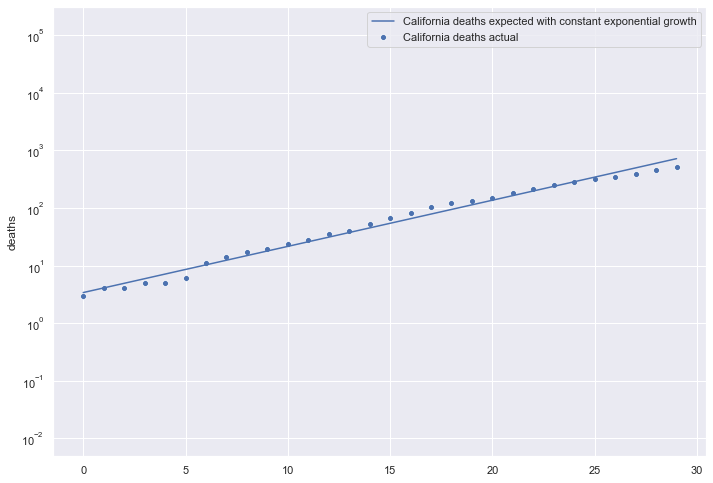

Trajectory plots for California, to see when the curve starts flattening


Correlations for California:


Deaths vs Lagged Values For California:


Deaths / Lagged Values For California:



### Analysis for Colorado ###

Colorado cases exponential formula fitted with 30 points:
cases = 46.46 * exp(0.1897 * day)
fitted daily growth rate: 20.89 %, fitted days to doubling: 3.65
actual daily growth rate: 5.84 %, actual days to doubling: 11.87


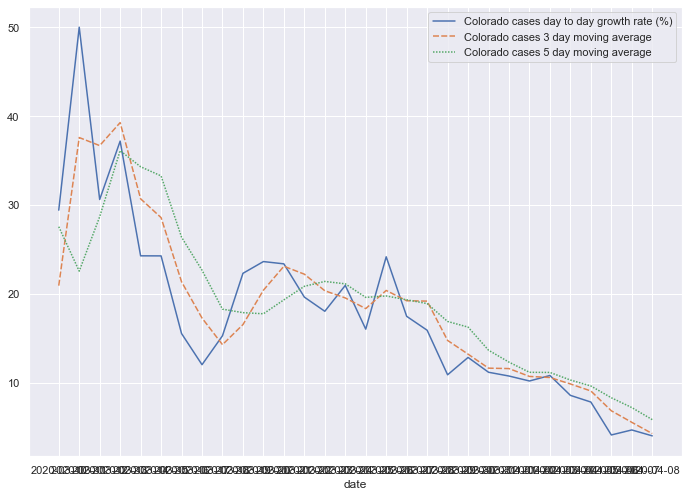

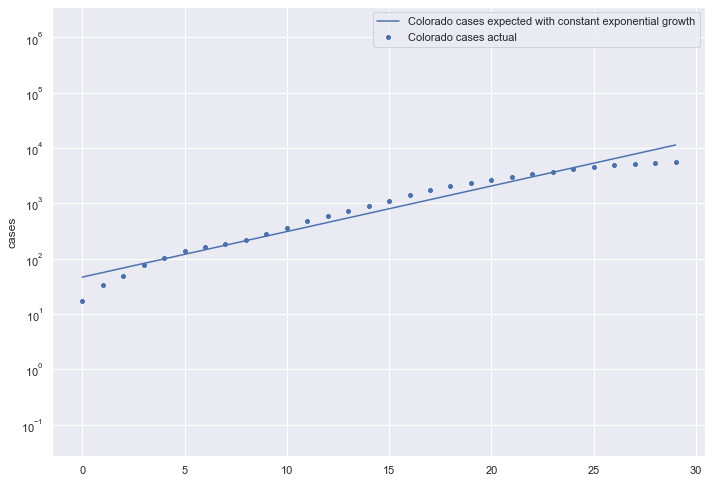

Colorado deaths exponential formula fitted with 28 points:
deaths = 1.16 * exp(0.203 * day)
fitted daily growth rate: 22.51 %, fitted days to doubling: 3.41
actual daily growth rate: 10.47 %, actual days to doubling: 6.62


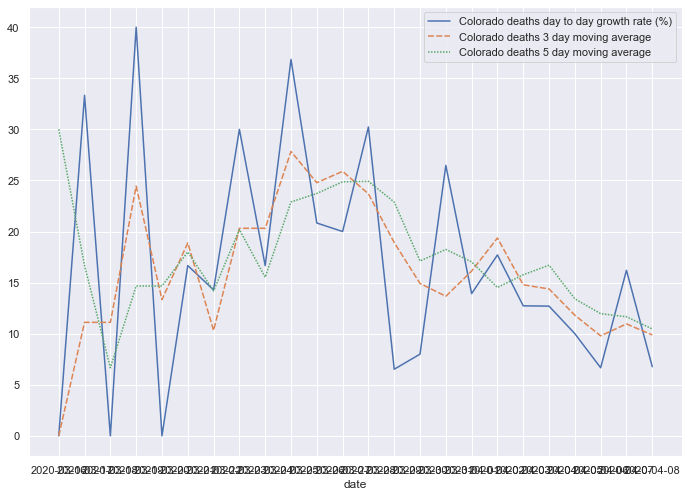

Trajectory plots for Colorado, to see when the curve starts flattening


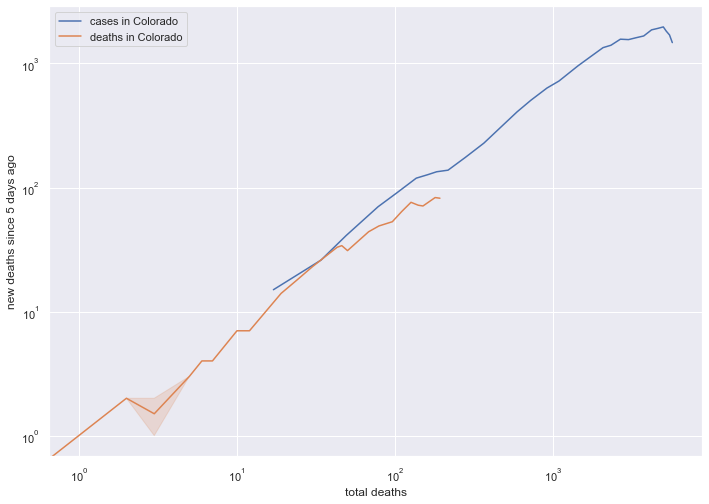

Correlations for Colorado:


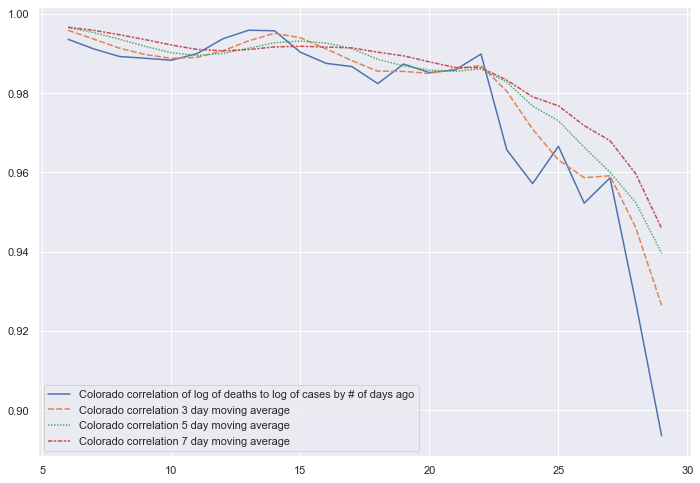

Deaths vs Lagged Values For Colorado:


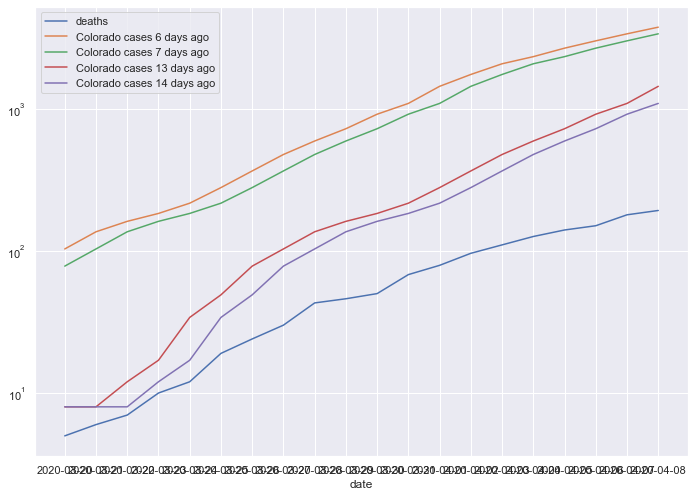

Deaths / Lagged Values For Colorado:


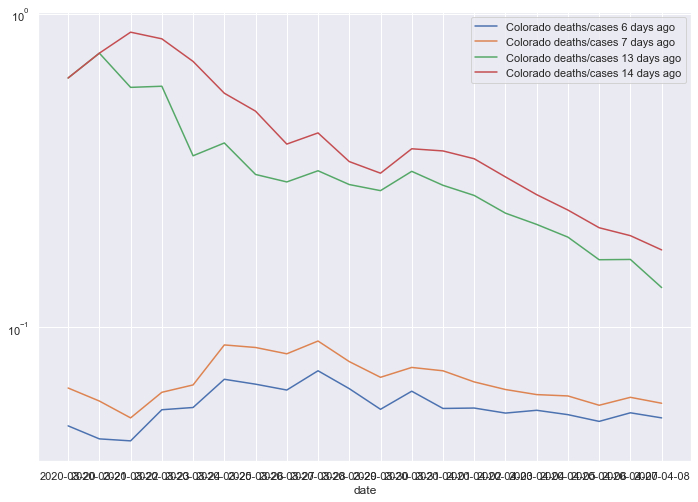


### Analysis for Arizona ###

Arizona cases exponential formula fitted with 30 points:
cases = 6.35 * exp(0.2383 * day)
fitted daily growth rate: 26.91 %, fitted days to doubling: 2.91
actual daily growth rate: 8.23 %, actual days to doubling: 8.42


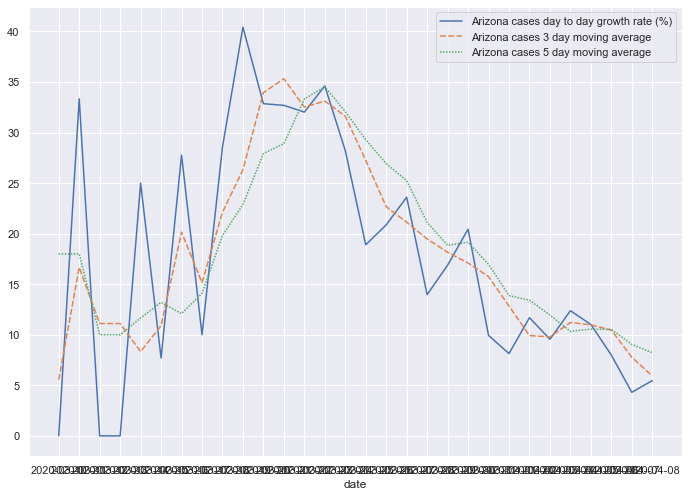

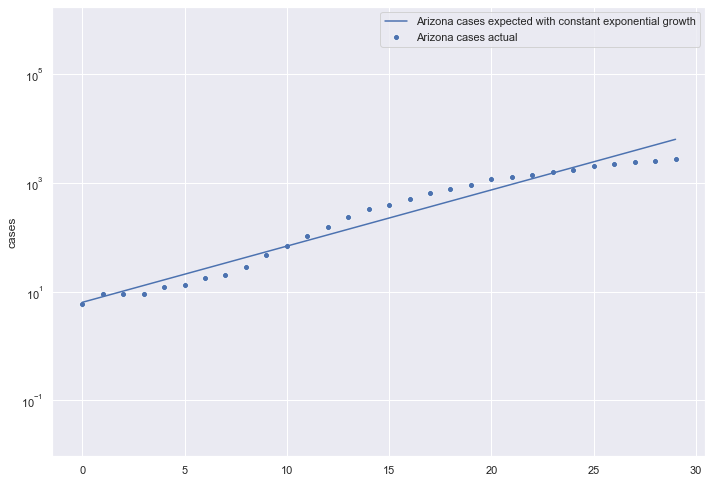

Arizona deaths exponential formula fitted with 20 points:
deaths = 1.16 * exp(0.245 * day)
fitted daily growth rate: 27.76 %, fitted days to doubling: 2.83
actual daily growth rate: 11.97 %, actual days to doubling: 5.79


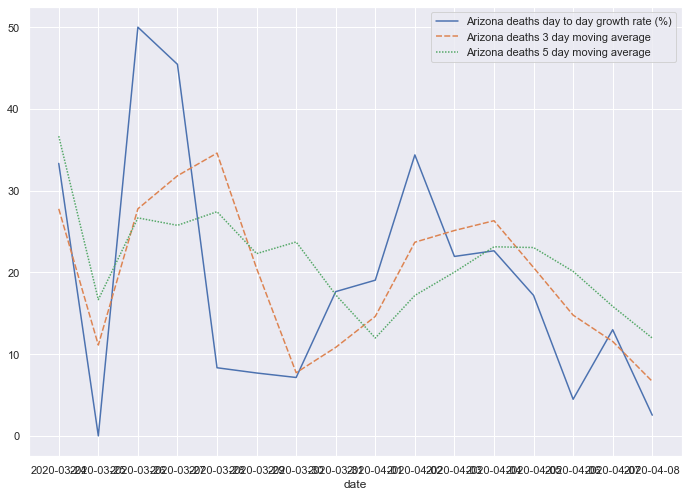

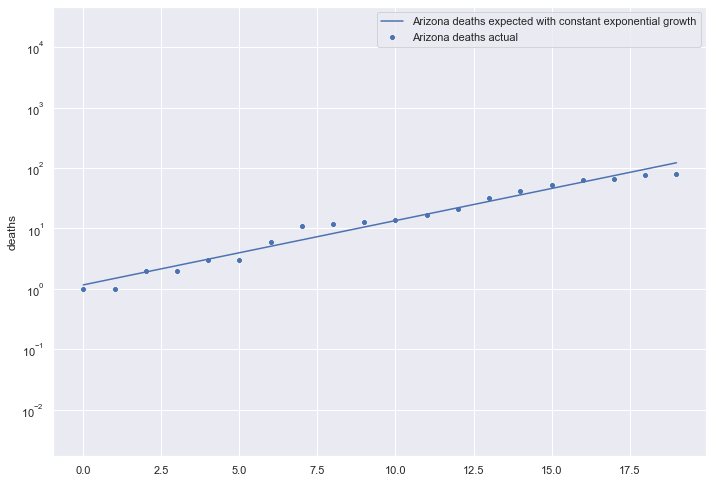

Trajectory plots for Arizona, to see when the curve starts flattening


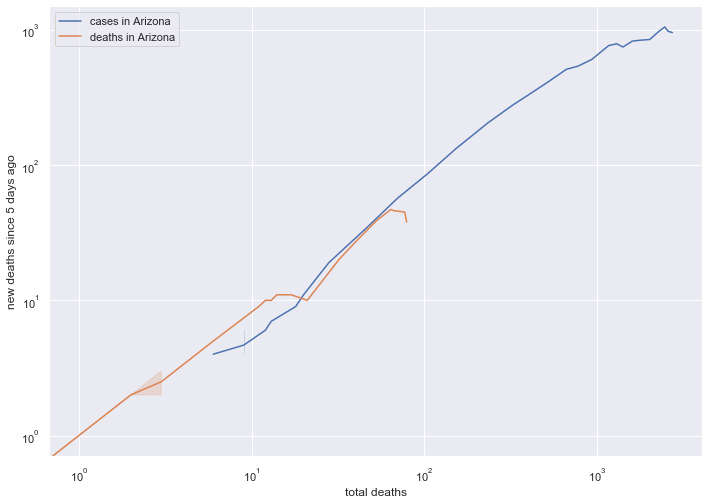

Correlations for Arizona:


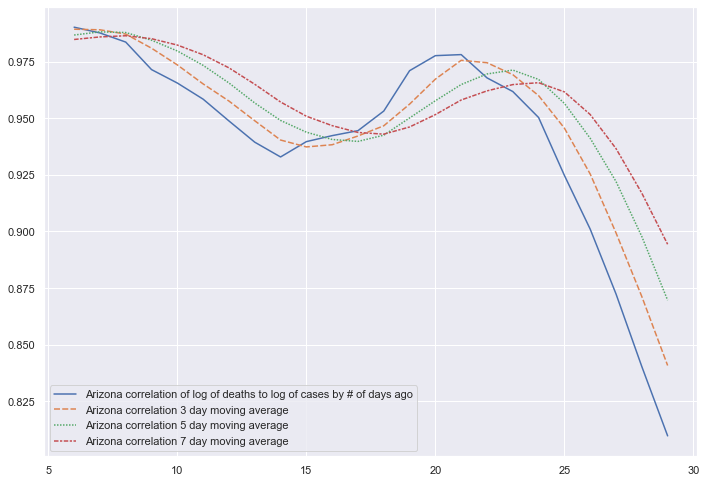

Deaths vs Lagged Values For Arizona:


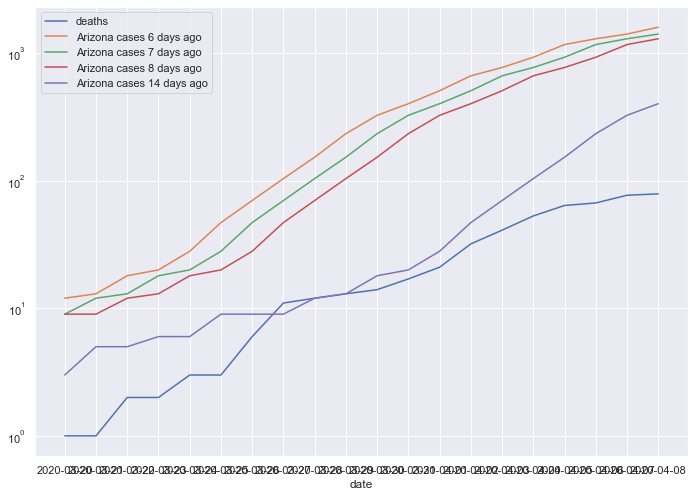

Deaths / Lagged Values For Arizona:


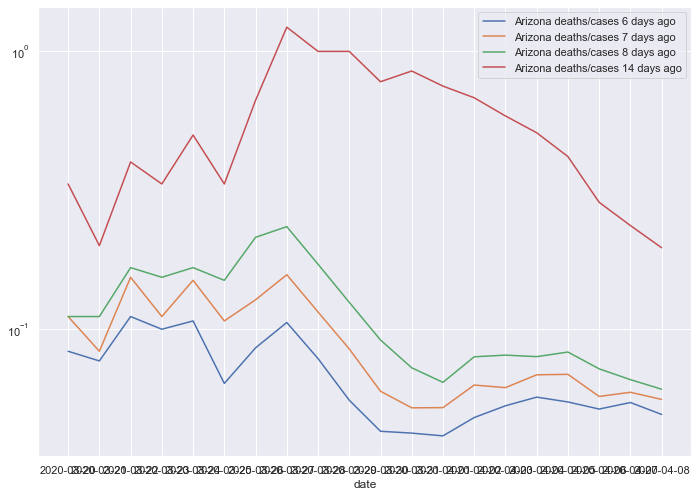


### Analysis for USA total: ###

USA total: cases exponential formula fitted with 30 points:
cases = 1532.17 * exp(0.2202 * day)
fitted daily growth rate: 24.64 %, fitted days to doubling: 3.15
actual daily growth rate: 8.43 %, actual days to doubling: 8.22


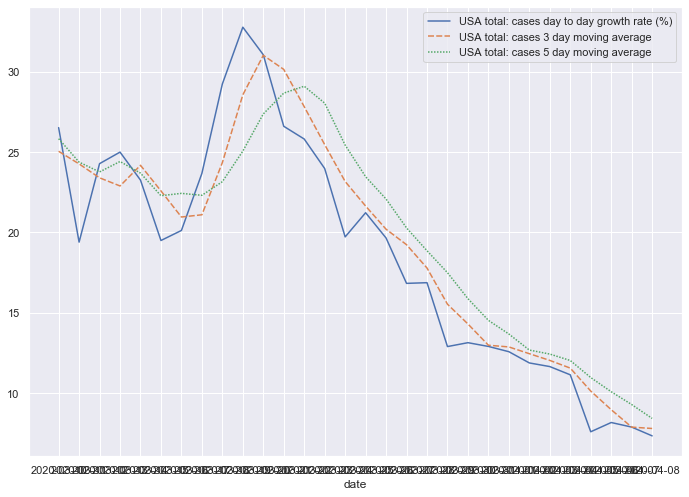

USA total: deaths exponential formula fitted with 30 points:
deaths = 27.37 * exp(0.2287 * day)
fitted daily growth rate: 25.69 %, fitted days to doubling: 3.03
actual daily growth rate: 13.53 %, actual days to doubling: 5.12


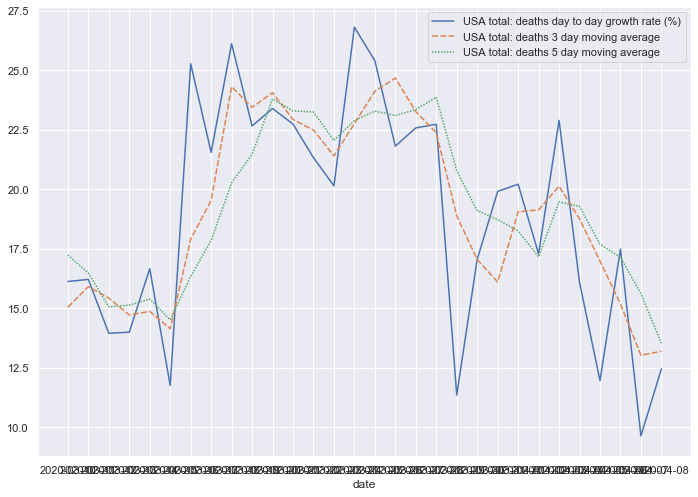

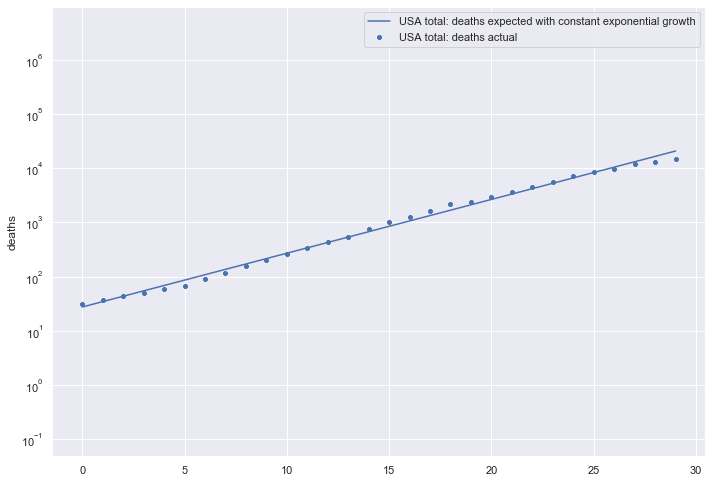

Trajectory plots for USA total:, to see when the curve starts flattening


Correlations for USA total::


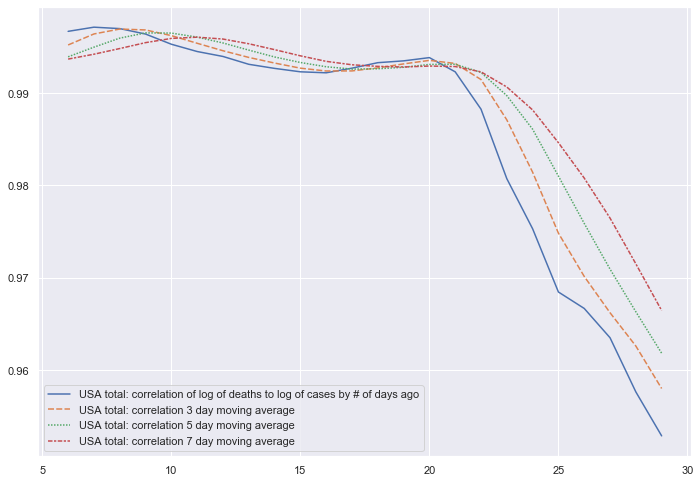

Deaths vs Lagged Values For USA total::


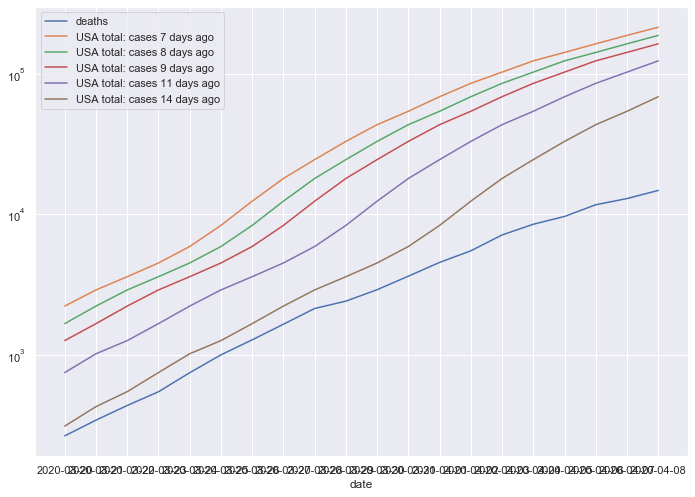

Deaths / Lagged Values For USA total::


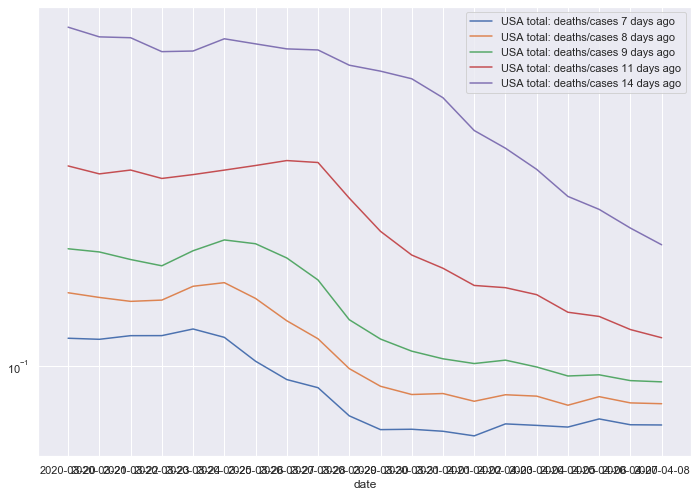

In [14]:
counties =["San Francisco", "Los Angeles", "Boulder", "Denver", "New York City"]
states = [ "California", "Colorado", "Arizona"]
analyse(counties=counties, states=states)

In [15]:
# counties with the most deaths today
today = rawData.tail(1).date.values[0]
rawData[rawData.date == today].groupby(['state', 'county']).sum().sort_values('deaths', ascending=False)

fips  cases  deaths
state         county                               
New York      New York City      0.0  81803    4571
              Nassau         36059.0  18548     701
Michigan      Wayne          26163.0   9626     446
New York      Westchester    36119.0  15887     343
              Suffolk        36103.0  15844     328
New Jersey    Bergen         34003.0   7874     314
Illinois      Cook           17031.0  10520     312
New Jersey    Essex          34013.0   5598     276
Washington    King           53033.0   3690     246
Michigan      Oakland        26125.0   4007     234
Louisiana     Orleans        22071.0   5070     208
California    Los Angeles     6037.0   7530     198
Connecticut   Fairfield       9001.0   4417     155
Louisiana     Jefferson      22051.0   4092     149
Michigan      Macomb         26099.0   2626     141
New Jersey    Middlesex      34023.0   4156     139
              Union          34039.0   4831     125
              Hudson         34017.0   5437     122
              Morris         34027.0   2468     102
              Ocean          34029.0   2856     101
New York      Rockland       36087.0   6413      98
Pennsylvania  Philadelphia   42101.0   4456      86
New Jersey    Monmouth       34025.0   3038      86
Washington    Snohomish      53061.0   1694      85
Massachusetts Middlesex      25017.0   3545      80
New Jersey    Passaic        34031.0   4372      71
Connecticut   New Haven       9009.0   1945      70
Florida       Palm Beach     12099.0   1222      69
Connecticut   Hartford        9003.0   1290      68
New York      Orange         36071.0   3865      68
...                              ...    ...     ...
Maryland      Queen Anne's   24035.0     16       0
Michigan      Ogemaw         26129.0      3       0
              Delta          26041.0      8       0
              Newaygo        26123.0      3       0
              Monroe         26115.0    152       0
              Mason          26105.0      1       0
              Manistee       26101.0      9       0
              Mackinac       26097.0      3       0
              Luce           26095.0      1       0
              Lenawee        26091.0     36       0
              Leelanau       26089.0      4       0
              Huron          26063.0      4       0
              Houghton       26061.0      1       0
              Gratiot        26057.0      5       0
              Gladwin        26051.0      4       0
              Clare          26035.0      3       0
Maryland      Somerset       24039.0      4       0
Michigan      Chippewa       26033.0      1       0
              Charlevoix     26029.0      8       0
              Bay            26017.0     39       0
              Barry          26015.0      7       0
              Arenac         26011.0      4       0
              Antrim         26009.0      6       0
              Allegan        26005.0     18       0
Massachusetts Nantucket      25019.0      9       0
              Dukes          25007.0      8       0
Maryland      Worcester      24047.0     10       0
              Washington     24043.0     57       0
              St. Mary's     24037.0     62       0
Wyoming       Washakie       56043.0      4       0

[2565 rows x 3 columns]

In [16]:
# counties with the most cases today
rawData[rawData.date == today].groupby(['state', 'county']).sum().sort_values('deaths', ascending=False)

fips  cases  deaths
state         county                               
New York      New York City      0.0  81803    4571
              Nassau         36059.0  18548     701
Michigan      Wayne          26163.0   9626     446
New York      Westchester    36119.0  15887     343
              Suffolk        36103.0  15844     328
New Jersey    Bergen         34003.0   7874     314
Illinois      Cook           17031.0  10520     312
New Jersey    Essex          34013.0   5598     276
Washington    King           53033.0   3690     246
Michigan      Oakland        26125.0   4007     234
Louisiana     Orleans        22071.0   5070     208
California    Los Angeles     6037.0   7530     198
Connecticut   Fairfield       9001.0   4417     155
Louisiana     Jefferson      22051.0   4092     149
Michigan      Macomb         26099.0   2626     141
New Jersey    Middlesex      34023.0   4156     139
              Union          34039.0   4831     125
              Hudson         34017.0   5437     122
              Morris         34027.0   2468     102
              Ocean          34029.0   2856     101
New York      Rockland       36087.0   6413      98
Pennsylvania  Philadelphia   42101.0   4456      86
New Jersey    Monmouth       34025.0   3038      86
Washington    Snohomish      53061.0   1694      85
Massachusetts Middlesex      25017.0   3545      80
New Jersey    Passaic        34031.0   4372      71
Connecticut   New Haven       9009.0   1945      70
Florida       Palm Beach     12099.0   1222      69
Connecticut   Hartford        9003.0   1290      68
New York      Orange         36071.0   3865      68
...                              ...    ...     ...
Maryland      Queen Anne's   24035.0     16       0
Michigan      Ogemaw         26129.0      3       0
              Delta          26041.0      8       0
              Newaygo        26123.0      3       0
              Monroe         26115.0    152       0
              Mason          26105.0      1       0
              Manistee       26101.0      9       0
              Mackinac       26097.0      3       0
              Luce           26095.0      1       0
              Lenawee        26091.0     36       0
              Leelanau       26089.0      4       0
              Huron          26063.0      4       0
              Houghton       26061.0      1       0
              Gratiot        26057.0      5       0
              Gladwin        26051.0      4       0
              Clare          26035.0      3       0
Maryland      Somerset       24039.0      4       0
Michigan      Chippewa       26033.0      1       0
              Charlevoix     26029.0      8       0
              Bay            26017.0     39       0
              Barry          26015.0      7       0
              Arenac         26011.0      4       0
              Antrim         26009.0      6       0
              Allegan        26005.0     18       0
Massachusetts Nantucket      25019.0      9       0
              Dukes          25007.0      8       0
Maryland      Worcester      24047.0     10       0
              Washington     24043.0     57       0
              St. Mary's     24037.0     62       0
Wyoming       Washakie       56043.0      4       0

[2565 rows x 3 columns]